Data is collected at location Nes, Ameland.
The data is from water hight and water temperature.

The research question states:
How does the independent variable water temperature influence the dependent variable of water hight?

In [319]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, time
from scipy.stats import f_oneway
import seaborn as sns

In [320]:
Hight = pd.read_csv("C:\\Users\\Pin\\Desktop\\DataSets\\NVT_Hm0_NES.csv",sep = ";", header = 0)
Temp = pd.read_csv("C:\\Users\\Pin\\Desktop\\DataSets\\NVT_T_NES.csv", sep = ";", header = 0)

In [321]:
def Cleanup(DataFrame):
    """
    Removes columns without any values
    Drops columns with no meaningfull values
    Drops rows with any nan value
    """
    DataFrame = DataFrame.dropna(how = "all", axis = "columns")
    DataFrame = DataFrame.drop(columns = {"Referentievlak","Bemonsteringshoogte"})
    DataFrame = DataFrame.dropna(axis = 0, how = "any")
    return DataFrame

In [322]:
def Translate(DataFrame):
    """
    Translates all dutch to english
    Replaces oC with °C
    """
    degree_sign = u"\N{DEGREE SIGN}"
    Rename_dict = {"Datum":"Date",
                   "Tijd":"Time",
                   "Locatie":"Location",
                   "Waarde":"Value",
                   "Eenheid":"Unit",
                   "Windrichting":"Winddirection",
                   "Windrichting eenheid":"Wind direction unit"}
    DataFrame = DataFrame.rename(columns = Rename_dict)
    DataFrame = DataFrame.replace(["Significante golfhoogte in het spectrale domein Oppervlaktewater golffrequentie tussen 30 en 500 mHz in cm", "Temperatuur Oppervlaktewater oC", "graden", "oC"],
                                   ["Significant wave height in the spectral domain Surface water wave frequency between 30 and 500 mHz in cm","Temperature surface water " + degree_sign + "C", "Degrees", degree_sign + "C"])
    return DataFrame

In [323]:
def CombineAndDrop(DataFrame):
    """
    Renames columns to add their unit
    Removes columns that are not used, like the seperate unit column
    """
    Unused = {"Parameter", "Location", "Unit", "Wind direction unit"}
    DataFrame = DataFrame.replace("Significant wave height in the spectral domain Surface water wave frequency between 30 and 500 mHz in cm","Wave hight in cm")
    Rename_dict = {"Value": DataFrame["Parameter"].iloc[0],
                   "Winddirection": "Winddirection in " + DataFrame["Wind direction unit"].iloc[0]}
    DataFrame = DataFrame.rename(columns = Rename_dict)
    DataFrame = DataFrame.drop(columns = Unused)
    
    return DataFrame

In [324]:
def AddTime(DataFrame):
    """
    Adds the time column to the date column
    """
    DataFrame["DateTime"] = DataFrame["Date"] + " " + DataFrame["Time"]
    DataFrame = DataFrame.drop(columns = {"Date", "Time"})
    return DataFrame

In [325]:
def ConvertToNumeric(DataFrame):
    """
    Replaces , with . and then converts the column to numeric
    """
    DataFrame = DataFrame.replace(",", ".", regex = True)
    DataFrame = DataFrame.apply(lambda col:pd.to_numeric(col, errors="ignore"))#errors = ignore so it lets strings remain as non-null objects.
    return DataFrame

In [326]:
def Preproccessing(DataFrame):
    DataFrame = Cleanup(DataFrame)
    DataFrame = Translate(DataFrame)
    DataFrame = CombineAndDrop(DataFrame)
    DataFrame = AddTime(DataFrame)
    DataFrame = ConvertToNumeric(DataFrame)

    return DataFrame

In [327]:
def CombineFrames(DataFrame1, DataFrame2, NameDataFrame1, NameDataFrame2):
    DataFrame1 = DataFrame1.set_index("DateTime")
    DataFrame2 = DataFrame2.set_index("DateTime")
    DataFrameComb = pd.merge(DataFrame1, DataFrame2, left_index = True, right_index = True, suffixes = ("_" + NameDataFrame1, "_" + NameDataFrame2))
    return DataFrameComb

In [328]:
Hight = Preproccessing(Hight)
Temp = Preproccessing(Temp)
Frame = CombineFrames(Hight, Temp, "Hight", "Temp")

In [346]:
Frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4028 entries, 1-1-2022 15:00:00 to 29-1-2022 14:30:00
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Wave hight in cm                4028 non-null   float64
 1   Winddirection in Degrees_Hight  4028 non-null   int64  
 2   Temperature surface water °C    4028 non-null   float64
 3   Winddirection in Degrees_Temp   4028 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 157.3+ KB


In [343]:
Array1 = Frame["Wave hight in cm"].to_numpy()
Array2 = Frame["Temperature surface water °C"].to_numpy()

In [345]:
print(Array1)
print(Array2)

[14. 14. 14. ... 33. 35. 35.]
[5.6 5.7 5.6 ... 5.4 5.4 5.4]


In [344]:
f_oneway(Array1, Array2)

F_onewayResult(statistic=9755.810588771801, pvalue=0.0)

In [329]:
f_oneway(Frame["Wave hight in cm"], Frame["Temperature surface water °C"])

F_onewayResult(statistic=9755.810588771801, pvalue=0.0)

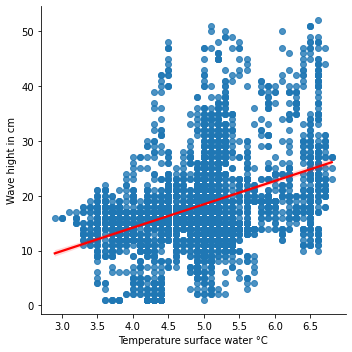

In [331]:
sns.lmplot(x="Temperature surface water °C", y="Wave hight in cm", data=Frame, fit_reg=True, line_kws = {"color": "red"})

In [332]:
#one way ANOVA test, t-test

<AxesSubplot:xlabel='DateTime'>

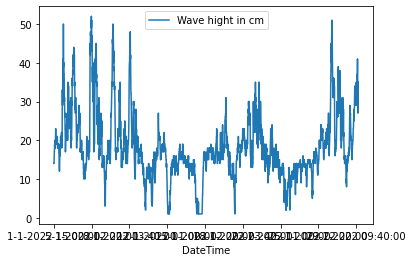

In [334]:
Hight.plot(x = "DateTime", y = "Wave hight in cm")

<AxesSubplot:xlabel='DateTime'>

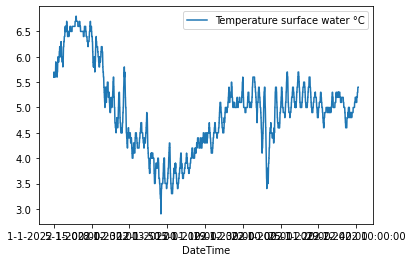

In [335]:
Temp.plot(x = "DateTime", y = "Temperature surface water °C")

In [336]:
Hight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4030 entries, 0 to 4029
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wave hight in cm          4030 non-null   float64
 1   Winddirection in Degrees  4030 non-null   int64  
 2   DateTime                  4030 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 125.9+ KB


In [337]:
Temp

,Temperature surface water °C,Winddirection in Degrees,DateTime
0,5.6,183.3,1-1-2022 15:00:00
1,5.7,182.2,1-1-2022 15:10:00
2,5.6,179.7,1-1-2022 15:20:00
3,5.6,181.7,1-1-2022 15:30:00
4,5.6,180.6,1-1-2022 15:40:00
...,...,...,...
4026,5.4,231.0,29-1-2022 14:00:00
4027,5.4,227.9,29-1-2022 14:10:00
4028,5.4,227.1,29-1-2022 14:20:00
4029,5.4,229.8,29-1-2022 14:30:00
